## Project Overview

The Animal Classification Project aims to develop a deep learning model to classify images of animals into three categories: cats, dogs, and snakes. The model leverages transfer learning with MobileNetV2, a lightweight and efficient convolutional neural network pre-trained on ImageNet, to achieve high accuracy on a relatively small dataset. The project involves data splitting, preprocessing, model training, evaluation, and analysis of misclassifications to ensure robust performance.

## Objectives


- Build a classifier to accurately distinguish between cats, dogs, and snakes.

- Use transfer learning to overcome the limitations of a small dataset (3,000 images).

- Achieve a test accuracy of at least 95% while ensuring generalization.

- Analyze model performance using metrics like accuracy, confusion matrix, and classification report.

## Tools and Technologies:

- Programming Language: Python

- Deep Learning Framework: TensorFlow/Keras

- Pre-trained Model: MobileNetV2

- Libraries: NumPy, scikit-learn, Seaborn, Matplotlib




In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import os
import shutil
import glob

In [3]:
print(os.getcwd())

C:\Users\user\anaconda3\envs\mlp\Animal classification


### Dataset Description

The dataset consists of 3,000 images divided equally across three classes:

- Cats: 1,000 images

- Dogs: 1,000 images

- Snakes: 1,000 images

The images are organized in three folders (cat, dog, snake) within a root directory. Each image is in a common format (.jpg).

### Data Splitting

To prevent information leakage and ensure fair evaluation, the dataset is split into training, validation, and test sets before preprocessing:

- Training: 70% (2,100 images, ~700 per class)

- Validation: 15% (450 images, 150 per class)

- Test: 15% (450 images, 150 per class)

The split is performed using stratified sampling to maintain class balance, and the resulting images are saved in a directory structure (split_animal_dataset/train/cat, split_animal_dataset/val/dog, etc.).



In [5]:
dataset_path = r'C:\Users\user\anaconda3\envs\mlp\Animal classification\Dataset'
classes = os.listdir(dataset_path)
print("Number of classes:", len(classes))
print("Class names:", classes[:])  
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(dataset_path, cls)))} images")

Number of classes: 3
Class names: ['cats', 'dogs', 'snakes']
cats: 1000 images
dogs: 1000 images
snakes: 1000 images


## Methodology

## 1. Data Splitting

The dataset is split using a custom Python function that:

- Reads images from the class folders (cat, dog, snake).

- Splits each class’s images into training, validation, and test sets (70/15/15 ratio).

- Copies images to a new directory structure for easy loading.

- Returns a dictionary with file paths and labels for flexibility.

In [7]:
# splitting the dataset
def load_and_split_dataset(data_dir, train_size=0.7, val_size=0.15, output_dir="split_dataset", random_state=42):
    """
    Loads images from class folders and splits them into training, validation, and test sets.
    
    Parameters:
    data_dir: path to dataset directory containing 'cat', 'dog', 'snake' folders
    train_size: proportion of data for training
    val_size: proportion of data for validation
    output_dir: directory to save split datasets
    random_state: seed for reproducibility
    
    Returns:
    Dictionary with split file paths and labels
    """
    # Defining classes and splitings
    classes = ['cats', 'dogs', 'snakes']
    test_size = 1.0 - train_size - val_size
    
    # Initializing lists to store file paths and labels
    split_data = {
        'train': {'files': [], 'labels': []},
        'val': {'files': [], 'labels': []},
        'test': {'files': [], 'labels': []}
    }
    
    # Creating output directories
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    for split in ['train', 'val', 'test']:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)
    
    # Processing each class
    for cls in classes:
        class_dir = os.path.join(data_dir, cls)
        if not os.path.exists(class_dir):
            raise FileNotFoundError(f"Directory {class_dir} not found")
        
        # Geting all image files
        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        if len(files) != 1000:
            print(f"Warning: Found {len(files)} images in {class_dir}, expected 1000")
        
        # Creating labels for this class
        labels = [cls] * len(files)
        
        # First split: train vs (val + test)
        train_files, temp_files, train_labels, temp_labels = train_test_split(
            files, labels, train_size=train_size, random_state=random_state
        )
        
        # Adjust val_size for second split
        relative_val_size = val_size / (val_size + test_size)
        
        # Second split: val vs test
        val_files, test_files, val_labels, test_labels = train_test_split(
            temp_files, temp_labels, train_size=relative_val_size, random_state=random_state
        )
        
        # Store in split_data
        split_data['train']['files'].extend(train_files)
        split_data['train']['labels'].extend(train_labels)
        split_data['val']['files'].extend(val_files)
        split_data['val']['labels'].extend(val_labels)
        split_data['test']['files'].extend(test_files)
        split_data['test']['labels'].extend(test_labels)
        
        # Copy files to output directories
        for split, split_files in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file_path in split_files:
                dest_path = os.path.join(output_dir, split, cls, os.path.basename(file_path))
                shutil.copy(file_path, dest_path)
    
    # Print summary
    for split in ['train', 'val', 'test']:
        print(f"{split.capitalize()} set: {len(split_data[split]['files'])} images")
        for cls in classes:
            cls_count = split_data[split]['labels'].count(cls)
            print(f"  {cls}: {cls_count} images")
    
    return split_data



In [8]:
split_data = load_and_split_dataset(dataset_path, output_dir="split_animal_dataset")

Train set: 2100 images
  cats: 700 images
  dogs: 700 images
  snakes: 700 images
Val set: 447 images
  cats: 149 images
  dogs: 149 images
  snakes: 149 images
Test set: 453 images
  cats: 151 images
  dogs: 151 images
  snakes: 151 images


## 2. Data Preprocessing

- Images were resized to 224x224 pixels to match MobileNetV2’s input requirements.
- Applied MobileNetV2’s preprocess_input function for normalization.
- Used data augmentation on the training set to improve generalization: Rotation, width/height shifts, shear, zoom, and horizontal flips.
- Validation and test sets were not augmented, only preprocessed to avoid information leakage.

In [10]:
base_path = r'C:\Users\user\anaconda3\envs\mlp\Animal classification\split_animal_dataset'
    # Creating data generators
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
valid_datagen = ImageDataGenerator(rescale=1./255)

    # Loading training data
train_generator = train_datagen.flow_from_directory(
        os.path.join(base_path, 'train'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    # Loading validation data
valid_generator = valid_datagen.flow_from_directory(
        os.path.join(base_path, 'val'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Loading test data
test_generator = valid_datagen.flow_from_directory(
        os.path.join(base_path, 'test'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

Found 2100 images belonging to 3 classes.
Found 447 images belonging to 3 classes.
Found 453 images belonging to 3 classes.


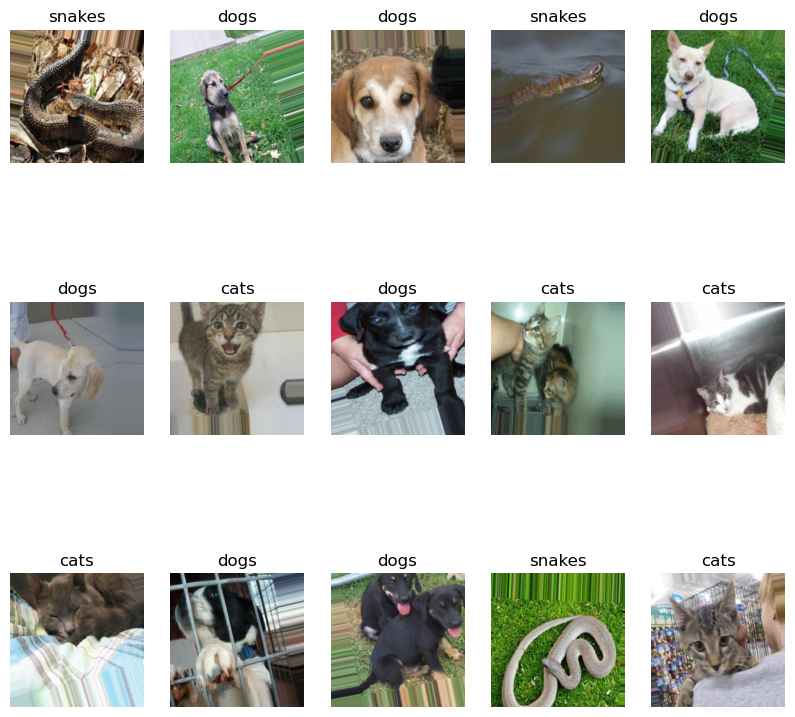

In [11]:
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title(list(train_generator.class_indices.keys())[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

## 3. Model Architecture

The model uses MobileNetV2 for transfer learning:

- Base Model: MobileNetV2 pre-trained on ImageNet, with the top classification layer removed (include_top=False).
- Feature Extraction: The base model is initially frozen (trainable=False) to use its pre-trained weights as a feature extractor.
- Custom Layers:
  - Global average pooling to reduce spatial dimensions.
  - Dropout layer (0.2) to prevent overfitting.
  - Dense layer (128 units, ReLU activation) for task-specific learning.
  - Output layer (3 units, softmax activation) for classifying cats, dogs, and snakes.
- Input Shape: 224x224x3 (RGB images).

In [13]:
# Step 1: Defining the base model (MobileNetV2)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Step 2: Freezing the base model
base_model.trainable = False

# Step 3: Building the custom model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Step 5: Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Model Training
- Optimizer: Adam with an initial learning rate of 0.001.
- Loss Function: Sparse categorical crossentropy (suitable for integer labels: 0 for cat, 1 for dog, 2 for snake).
- Metrics: Accuracy, losses.
- Epochs: Trained for 11 epochs (out of 20 planned), with a learning rate scheduler reducing the learning rate to 2e-4 (Epoch 6) and 4e-5 (Epoch 10).
- Batch Size: 32.
- Training Setup: The base model is frozen during initial training to train only the custom layers..

In [15]:
# Loading the saved weights
best_model = model.load_weights(r'C:\Users\user\anaconda3\envs\mlp\Animal classification\mobilnet_best_model.keras')

In [16]:
checkpoint = ModelCheckpoint(
   r'C:\Users\user\anaconda3\envs\mlp\Animal classification\mobilnet_best_model.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9768 - loss: 0.0770 - val_accuracy: 0.9888 - val_loss: 0.0771 - learning_rate: 0.0010
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9818 - loss: 0.0566 - val_accuracy: 0.9709 - val_loss: 0.1559 - learning_rate: 0.0010
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9777 - loss: 0.0916 - val_accuracy: 0.9888 - val_loss: 0.0806 - learning_rate: 0.0010
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9756 - loss: 0.0994 - val_accuracy: 0.9866 - val_loss: 0.0728 - learning_rate: 0.0010
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9758 - loss: 0.0840 - val_accuracy: 0.9888 - val_loss: 0.0677 - learning_rate: 0.0010
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9778 - loss: 0.0673 - val_accuracy: 0.9888 - val_loss: 0.0959 - learning_rate: 0.0010
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9795 - loss: 0.0609 - val_acc

In [17]:
# Evaluating model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9830 - loss: 0.0670
Test Loss: 0.0660, Test Accuracy: 0.9845


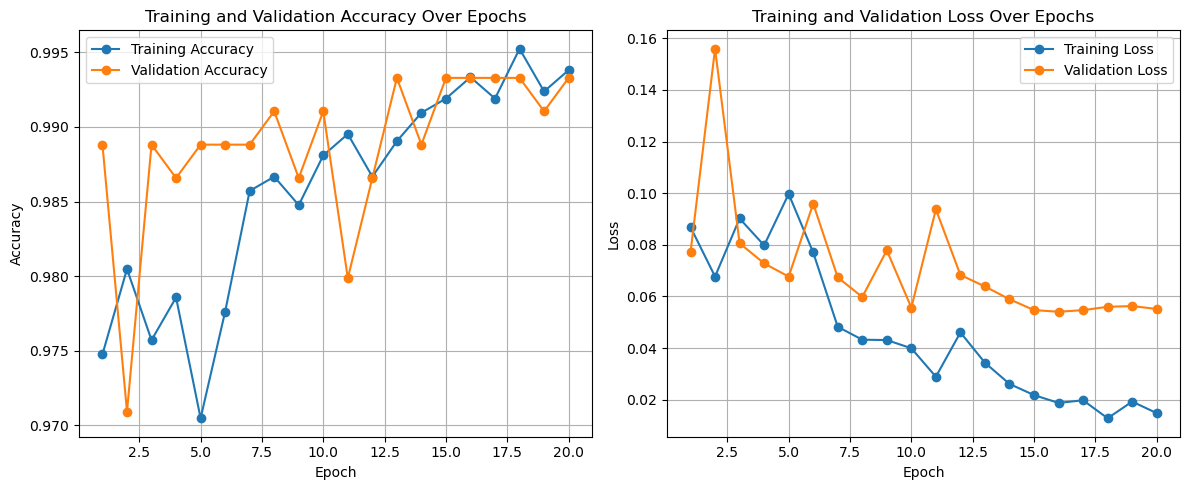

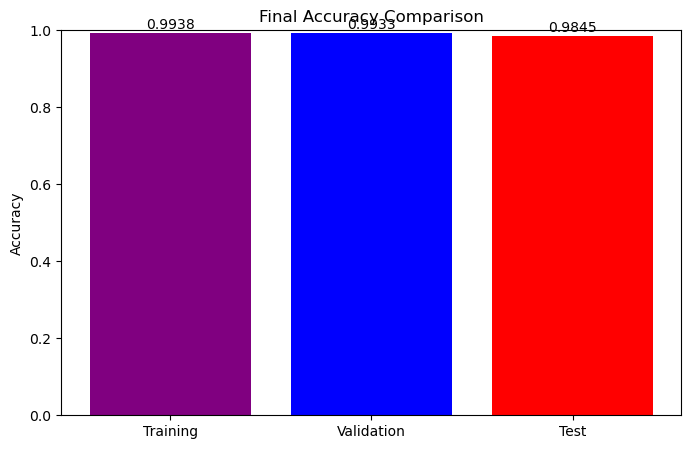

In [22]:
epochs = range(1, 21)  

# Extracting metrics from history (from this run)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Bar plot comparing final training, validation, and test accuracies
final_train_acc = train_acc[-1]  
final_val_acc = val_acc[-1]      
test_acc_value = 0.9845          

plt.figure(figsize=(8, 5))
labels = ['Training', 'Validation', 'Test']
accuracies = [final_train_acc, final_val_acc, test_acc_value]
plt.bar(labels, accuracies, color=['purple', 'blue', 'red'])
plt.title('Final Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

In [ ]:
y_pred = []
y_true = []
for images, labels in test_generator:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    # Check if labels is a tensor or already a NumPy array
    if hasattr(labels, 'numpy'):
        y_true.extend(labels.numpy())
    else:
        y_true.extend(labels)  # Assuming labels is already a NumPy array or compatible

# Converting lists to NumPy arrays for safety
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['cat', 'dog', 'snake']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━